In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qucat import Network, L,J,C,R
from numpy import pi

# Modelling a distributed multi-mode resonator

In this section we use QuCAT to study the convergence of parameters in the first order Hamiltonian 

$\hat{H} = \sum_m\sum_{n\ne m} (\hbar\omega_m-A_m-\frac{\chi_{mn}}{2})\hat{a}_m^\dagger\hat{a}_m 
-\frac{A_m}{2}\hat{a}_m^\dagger\hat{a}_m^\dagger\hat{a}_m\hat{a}_m -\chi_{mn}\hat{a}_m^\dagger\hat{a}_m\hat{a}_n^\dagger\hat{a}_n$

of a transmon qubit coupled to a multi-mode resonator. 
As done experimentally in https://arxiv.org/pdf/1704.06208.pdf and theoretically in https://arxiv.org/pdf/1701.05095.pdf

Using a length of coplanar waveguide terminated with engineered boundary conditions is a common way of building a microwave resonator.
One implementation is a $\lambda/4$ resonator terminated on one end by a large shunt capacitor, acting as a near-perfect short circuit for microwaves such that only a small amount of radiation may enter or leave the resonator.
The shunt capacitor creates a voltage node, and at the open end the voltage is free to oscillate, and can couple, as shown below to a transmon qubit.

![alt text](graphics/MMUSC_circuit.png "")

*optical micrograph from https://arxiv.org/abs/1704.06208*

This resonator hosts a number of normal modes, justifying its lumped element equivalent circuit shown in **(c)**, a series of LC oscillators with increasing resonance frequency.

We will use QuCAT to track the evolution of different characteristics of the system as the number of considered resonator modes $N$ increases.

We start by defining some constants

In [6]:
# fundamental mode frequency of the resonator
f0 = 4.603e9
w0 = f0*2.*pi
# characteristic impedance of the resonator
Z0 = 50
# Josephson energy (in Hertz)
Ej = 18.15e9
# Coupling capacitance
Cc = 40.3e-15
# Capacitance to ground
Cj = 5.13e-15

# Capacitance of all resonator modes
C0 = pi/4/w0/Z0
# Inductance of first resonator mode
L0 = 4*Z0/pi/w0

we can then generate a list of Qcircuits, each one corresponding to a different number of resonator modes $N$

In [3]:
# initialize list of Qcircuits for different number of resonator modes
qcircuits = []

# Maximum number of resonator modes we will be considering
N_max = 6


for N in range(1,N_max+1):
    # Initialize list of components for Transmon and coupling capacitor
    netlist = [
        J(N+2,1,Ej,use_E=True),
        C(N+2,1,Cj),
        C(1,2,Cc)]

    for m in range(N):
        # Nodes of m-th oscillator
        node_minus = 2+m
        node_plus = (2+m+1)
        # Inductance of m-th oscillator
        Lm = L0/(2*m+1)**2
        # Add oscillator to netlist
        netlist = netlist + [
            L(node_minus,node_plus,Lm),
            C(node_minus,node_plus,C0)]

    # Add Qcircuit to our list
    qcircuits.append(Network(netlist))

Note that $N+2$ is the index of the ground node.

We can now access some parameters of the system.

To get an initial idea of the mode distribution in the circuit, let us display the mode resonance frequencies and anharmonicities of the transmon coupled to 6 resonator modes

In [5]:
f,k,A,chi = qcircuits[-1].f_k_A_chi(pretty_print=True)

         mode |       freq.  |       diss.  |       anha.  |
            0 |     4.38 GHz |          0Hz |      196 kHz |
            1 |     8.05 GHz |          0Hz |      361 MHz |
            2 |       14 GHz |          0Hz |      2.6 MHz |
            3 |       23 GHz |          0Hz |      349 kHz |
            4 |     32.2 GHz |          0Hz |      134 kHz |
            5 |     41.3 GHz |          0Hz |     69.3 kHz |
            6 |     50.5 GHz |          0Hz |     39.4 kHz |

Kerr coefficients (diagonal = Kerr, off-diagonal = cross-Kerr)
         mode |         0    |         1    |         2    |         3    |         4    |         5    |         6    |
            0 |      196 kHz |              |              |              |              |              |              |
            1 |     16.8 MHz |      361 MHz |              |              |              |              |              |
            2 |     1.43 MHz |     61.3 MHz |      2.6 MHz |              |          

Mode `1`, is the only one with a significant anharmonicity and is thus the qubit-like mode.
A list of this modes frequencies, for varying number of resonator modes is given by

In [4]:
transmon_frequencies = [cir.eigenfrequencies()[1] for cir in qcircuits]

and the anharmonicity of the transmon, computed from first order perturbation theory is

In [5]:
transmon_anharmonicities = [cir.anharmonicities()[1] for cir in qcircuits]

Finally the Lamb shift, or shift in the transmon frequency resulting from the zero-point fluctuations of the resonator modes, is given, following the equation shown at the top of the page, by the sum of half the cross-Kerr couplings between the transmon mode and the others

In [6]:
lamb_shifts = []
for cir in qcircuits:
    lamb_shift = 0
    K = cir.kerr()
    N_modes = len(K[0])
    for m in range(N_modes):
        if m!=1:
            lamb_shift = lamb_shift + K[1][m]/2
    lamb_shifts.append(lamb_shift)

Finally, we can plot these parameters

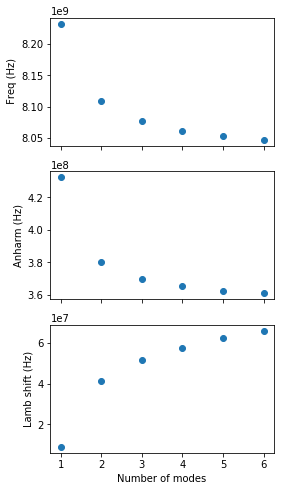

In [7]:
# Define plot with 3 subplots
fig,ax = plt.subplots(3,1,figsize = (4,8), sharex = True)

ax[0].plot(range(1,N_max+1),transmon_frequencies,'o')
# plot anharmonicity of the transmon
ax[1].plot(range(1,N_max+1),transmon_anharmonicities,'o')
# plot Lamb shift of the transmon 
ax[2].plot(range(1,N_max+1),lamb_shifts,'o')

ax[2].set_xlabel("Number of modes")
ax[0].set_ylabel(" Freq (Hz)")
ax[1].set_ylabel("Anharm (Hz)")
ax[2].set_ylabel("Lamb shift (Hz)")
plt.show()